In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms.functional import adjust_contrast
import matplotlib.pyplot as plt

C:\Users\tobia\anaconda3\envs\nerf\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\tobia\anaconda3\envs\nerf\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may h

In [3]:
from dataset import *

In [4]:
# Define a custom dataset class
class CorrectionImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, return_og=False):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)
        self.return_og = return_og

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
            

        if self.return_og:
            return self.hist_fix(image), image
        else:i
            return self.hist_fix(image)
    
    def hist_fix(self, im):
        new_im = im.clone()
        
        new_im[0] = (im[0] - torch.min(im[0])) / (torch.max(im[0])-torch.min(im[0]))
        new_im[1] = (im[1] - torch.min(im[1])) / (torch.max(im[1])-torch.min(im[1]))
        new_im[2] = (im[2] - torch.min(im[2])) / (torch.max(im[2])-torch.min(im[2]))

        return new_im


tensor(25517.1465)


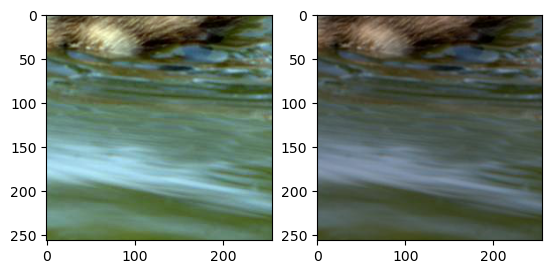

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.RandomCrop(size=(256, 256))
    ])

train_dataset = CorrectionImageDataset('data/training/GT_IMAGES', transform=transform, return_og=True)
validation_dataset = CorrectionImageDataset('data/validation/GT_IMAGES', transform=transform)

# test set must be done with the same data 
new_im, og_im = train_dataset[5]

fig, axs = plt.subplots(1,2)
axs[0].imshow(new_im.permute((1,2,0)))
axs[1].imshow(og_im.permute((1,2,0)))
print((new_im-og_im).sum())

In [6]:
len(train_dataset)

3535

In [7]:
len(validation_dataset)

150

# Training the model

In [24]:
from ddpm.ddpm import *
from ddpm.ddpm_train import *

BATCH_SIZE=2
RESIZE_SIZE = 256
IM_SIZE=64


transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(size=(RESIZE_SIZE, RESIZE_SIZE)),
    v2.RandomCrop(size=(IM_SIZE, IM_SIZE))
    ])

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else None)  
print(f"Model will run on {device}")


train_dataset = CorrectionImageDataset('data/training/GT_IMAGES', transform=transform, return_og=False)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train(dataloader, device=device, T=250, img_size=IM_SIZE, batch_size=BATCH_SIZE)

03:25:57 - INFO: Starting epoch 1:


Model will run on cuda


100%|██████████████████████████████████████████████████████████████████| 1768/1768 [14:59<00:00,  1.97it/s, MSE=0.0135]
03:40:57 - INFO: Sampling 1 new images....
100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:24<00:00, 20.65it/s]
03:41:21 - INFO: Starting epoch 2:
 35%|███████████████████████▌                                            | 612/1768 [05:08<09:42,  1.98it/s, MSE=0.074]


KeyboardInterrupt: 